In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import scipy as sp 
import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import matplotlib.dates as md

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# For a specific version of seaborn package 
!pip install seaborn==0.10.1

In [ ]:
# Set seaborn plotting style 
sns.set(context='talk', font_scale=0.9, style='ticks', palette='Blues_d')

In [ ]:
# Clone GitHub repo

Cloning into 'COVID19'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 522 (delta 164), reused 27 (delta 13), pack-reused 270
Receiving objects: 100% (522/522), 411.71 MiB | 20.85 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Checking out files: 100% (61/61), done.


In [ ]:
# change directory 
%cd /content/COVID19/data/processed 

/content/COVID19/data/processed


In [ ]:
# %ls # copy the name of the excel files you'll need 

In [ ]:
# Import Files #df = pd.read_excel('PADDED_Dataset_2020_08_10_GE50_Deaths.xlsx')
df7all = pd.read_excel('7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.xlsx')

# Drop unnecessary index columns #df.drop(columns='Unnamed: 0',axis=1,inplace=True)
df7all.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Tropic of Cancer is located at 23.5 degrees north of the equator and runs through Mexico, the Bahamas, Egypt, Saudi Arabia, India, and southern China
# The Tropic of Capricorn lies at 23.5 degrees south of the equator and runs through Australia, Chile, southern Brazil, and northern South Africa
upper_lat_bound = 23.5; lower_lat_bound = -23.5 
n_hem = df7all[df7all['Lat']>upper_lat_bound]; s_hem = df7all[df7all['Lat']<lower_lat_bound]; trop  = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>lower_lat_bound)]

print('Total Country Count:',df7all['Country'].unique().shape[0])
print('Northern Hemisphere Country Count:',n_hem['Country'].unique().shape[0])
print('Southern Hemisphere Country Count:',s_hem['Country'].unique().shape[0])
print('Tropics Country Count:',trop['Country'].unique().shape[0])

Total Country Count: 121
Northern Hemisphere Country Count: 67
Southern Hemisphere Country Count: 4
Tropics Country Count: 50


In [ ]:
# Assign the region name to each country in the dataset 
# df.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else # assigned n_hem if its in the list of northern hemisphere countries 
#                       's_hem' if country_name in s_hem['Country'].unique() else # assigned s_hem if its in the list of southern hemisphere countries 
#                       'trop' # assigned tropical if its neither northern or southern hemisphere 
#                       for country_name in df.loc[:,'Country']]
df7all.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else 's_hem' if country_name in s_hem['Country'].unique() else 'trop' for country_name in df7all.loc[:,'Country']]

In [ ]:
# List of other weather variables to look at... 
other_weather_vars = ['DailyTemp_C', 'Daily_UV', 'DailyRH_pct', 'DailyAH_gperm3']

In [ ]:
# Function to create lags of a given variable 

def make_lags(dataframe,merging_var,variable,num_lags):
  df = dataframe[['Country',merging_var,variable]].copy() # Make a copy of the country (for grouping) and the variable to be lagged  

  for i in range(1,num_lags+1):
    df[variable+'_lag{}'.format(i)] = df.groupby('Country')[variable].shift(i) # Create all of the lags of the given input variable 

  return df

In [ ]:
# Function to create a dataframe with lagged versions of the variable and the actual outbreak metrics 

def lagged_var_df(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  outcomes = df[COVIDstats]

  lagged_variables = make_lags(dataframe,merging_var,variable,num_lags)

  merged = lagged_variables.merge(right=outcomes,how='left',on=['Country',merging_var])

  return merged

In [ ]:
# Create a dataframe with lagged indoor humidity (from 0 days of lag up to 28 days of lag)
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

# List of other weather variables to look at... 
other_weather_vars = ['DailyTemp_C', 'Daily_UV', 'DailyRH_pct', 'DailyAH_gperm3']

# Dataframes with lagged variables 
df7all_lag_temp = lagged_var_df(df7all,'Days From 5th Death','DailyTemp_C',28,COVIDstats)
df7all_lag_uv = lagged_var_df(df7all,'Days From 5th Death','Daily_UV',28,COVIDstats)
df7all_lag_RH = lagged_var_df(df7all,'Days From 5th Death','DailyRH_pct',28,COVIDstats)
df7all_lag_AH = lagged_var_df(df7all,'Days From 5th Death','DailyAH_gperm3',28,COVIDstats)

In [ ]:
# List of lagged dataframes with other weather variables to look at... 
lagged_other_weather_vars = [df7all_lag_temp, df7all_lag_uv,df7all_lag_RH,df7all_lag_AH]

In [ ]:
def quantizer(dataframe, first_day, last_day, qlevels, countries, retbins):

  # Dataframe to use for plotting -> Set lower and upper bound for days from 5th death, only use the selected list of countries (could be all, n_hem, s_hem, trop, or for a given month)
  df = dataframe[(dataframe['Days From 5th Death'].ge(first_day)) & (dataframe['Days From 5th Death'].le(last_day)) & (dataframe['Country'].isin(countries))].copy()

  if retbins == True: # return the bin ranges and label each category with the bin range 
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,retbins=True,precision=1,duplicates='drop')[0]
  
  else: # don't retun the bin ranges and label each category with an integer
    # Apply qcut to break the outbreak metrics into different evenly-distributed quantiles 
    df.loc[:,'new_cases_Qlevels'] = pd.qcut(x=df.loc[:,'new_cases'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_diff_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_diff'],q=qlevels,duplicates='drop',labels=False).astype('category')
    df.loc[:,'new_deaths_pctchange_Qlevels'] = pd.qcut(x=df.loc[:,'new_deaths_pctchange'],q=qlevels,duplicates='drop',labels=False).astype('category')

  return df

In [ ]:
# Function for changing seaborn barplot width 
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [ ]:
import statsmodels.api as sm

def oddsratio(dataset,outcome,treatment):
  
  data = dataset[[outcome,treatment]].copy() # Copy dataset 

  contig_table = pd.crosstab(data[outcome],data[treatment]).iloc[::-1,] # Make a 2x2 contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 
  #print(contig_table)

  table = sm.stats.Table2x2(np.asarray(contig_table)) # Use statsmodels to turn the contingency table into a special 2x2 table for further statsmodels calculations 
  #print(table)

  #table=sm.stats.Table2x2.from_data(data) # Make a contingency table, 00 = Bad Outcome/No Treatment, 10 = Good Outcome/No Treatment, 01 = Bad Outcome/Treatment, 11 = Good Outcome/Treatment 

  odds_badoutcome_notreatment = contig_table.iloc[0,0]/contig_table.iloc[1,0] # Odds of having a worse outcome (e.g. more deaths) WITHOUT treatment (e.g. RH<40% or RH>60%) 
  odds_badoutcome_withtreatment = contig_table.iloc[0,1]/contig_table.iloc[1,1] # Odds of having a worse outcome (e.g. more deaths) WITH treatment (e.g. RH 40%-60%) 

  odds_ratio = table.oddsratio # Odds ratio (ratio of odds_badoutcome_notreatment to odds_badoutcome_withtreatment) -> how much more likely are you to have a bad outcome if you don't receive the treatment 
  LCB = table.oddsratio_confint()[0] # Lower 95% confidence boundary
  UCB = table.oddsratio_confint()[1] # Upper 95% confidence boundary 
  pval = table.oddsratio_pvalue() # p-value for a hypothesis test about the odds ratio

  return odds_badoutcome_notreatment, odds_badoutcome_withtreatment, odds_ratio, LCB, UCB, pval 

# To run function... 
# oddsratio(dataset=treat_total,outcome='new_cases_Qlevels',treatment='quantized_IndRH')

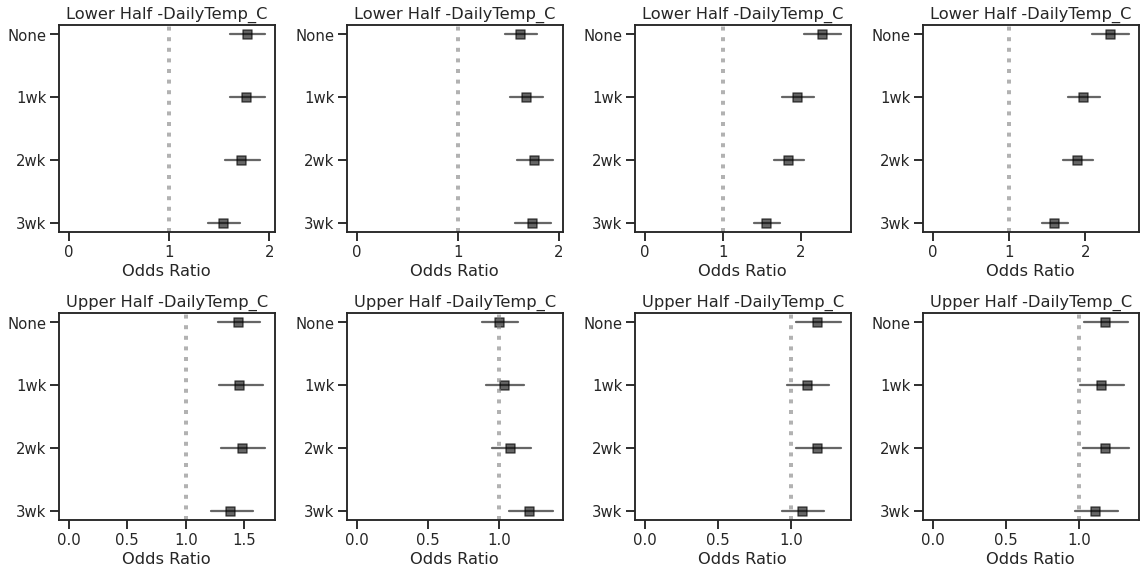

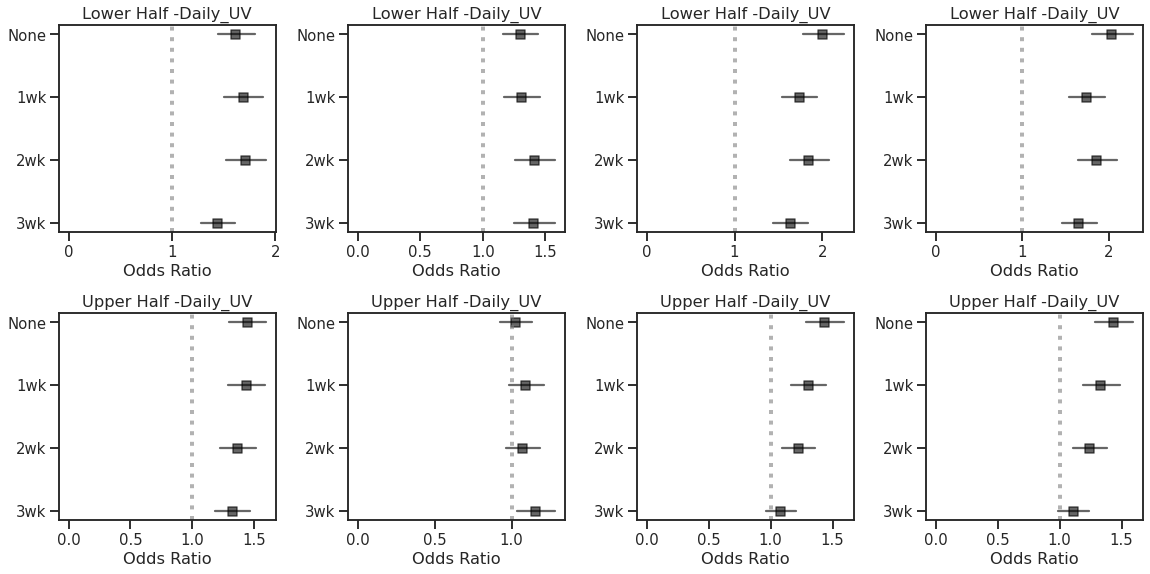

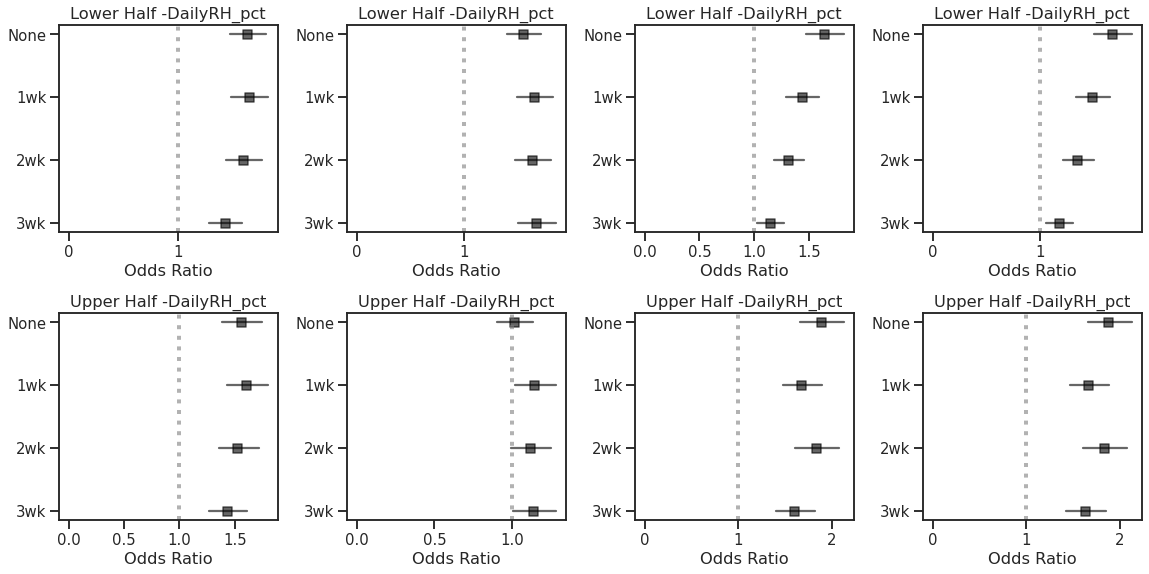

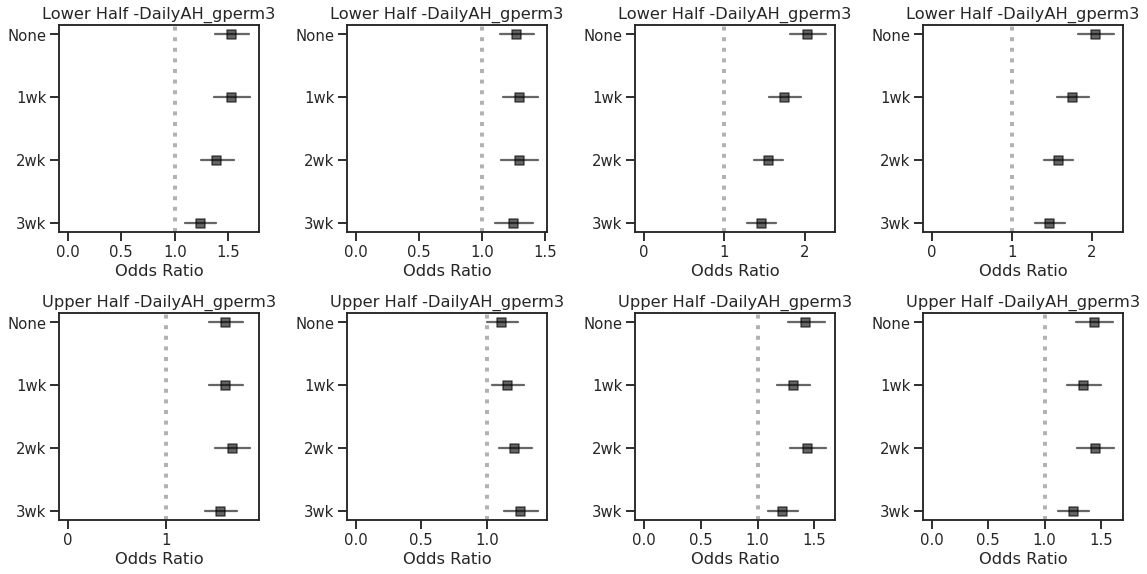

In [ ]:
# Use the old code to now get the lagged df with indoor humidity 

# Create a dataframe with lagged indoor humidity (from 0 days of lag up to 28 days of lag)
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

df7all_lag_indrh = lagged_var_df(df7all,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)

# Discretize the treatment  
bins = [0,40,60,100] # How to break up the continuous variable (0-40),(40-60),(60-100)
labels = [0,1,2] # How to label the bins 
df7all_lag_indrh['quantized_IndRH'] = pd.cut(df7all_lag_indrh['IndoorRH_pct'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag7'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag7'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag14'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag14'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag21'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag21'],bins=bins,labels=labels) # Use cut to break up the continuous data 

# Binarize the treatment (so <40 and >60 are untreated, 40-60 are treated) 
binary_treatment = df7all_lag_indrh.copy()
binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']] = binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']].replace(2,0)


for df7all_lag_VARIABLE in lagged_other_weather_vars:

  first_day = 0; last_day = 120;
  df7all_lag = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death'].ge(first_day)) & (df7all_lag_VARIABLE['Days From 5th Death'].le(last_day))].copy()

  treatment_qlevels = 2
  # Discretize the treatment  
  df7all_lag['weather_bins'] = pd.qcut(df7all_lag[df7all_lag.columns[2]],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag['weather_bins_lag7'] = pd.qcut(df7all_lag[df7all_lag.columns[2]+'_lag7'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag['weather_bins_lag14'] = pd.qcut(df7all_lag[df7all_lag.columns[2]+'_lag14'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag['weather_bins_lag21'] = pd.qcut(df7all_lag[df7all_lag.columns[2]+'_lag21'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 

  # Add the lagged, discretized weather variables to the binarized treatment dataframe 
  df_stratify_by_weather = pd.merge(binary_treatment, df7all_lag[['Country','Days From 5th Death','weather_bins','weather_bins_lag7','weather_bins_lag14','weather_bins_lag21']],on=['Country','Days From 5th Death'])

  # calculate the ORs 

  first_day = 0; last_day = 120; outbreak_qlevels=2
  quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels'] # outbreak metrics 
  quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21'] # time-lagged humidity 
  quantized_govbins = ['weather_bins','weather_bins_lag7','weather_bins_lag14','weather_bins_lag21'] # time-lagged gov stringency 
  bin_levels = np.arange(0,treatment_qlevels) # bin levels for government stringency 

  level3 = []
  for outcome in quantized_outcomes: 

    level2 = []
    for index in range(0,4): 

      humidity = quantized_humidities[index]
      govbin = quantized_govbins[index]

      level1 = [] 
      for level in bin_levels: 

        # Get a dataset where the time-lagged 'govbin' (e.g. govresp_bins_lag14) is equal to the defined 'level' (e.g. == 2)
        data = quantizer(dataframe=df_stratify_by_weather[df_stratify_by_weather[govbin]==level], first_day=first_day, last_day=last_day, qlevels=outbreak_qlevels, countries=df7all['Country'].unique(), retbins=False).dropna()
        #print(outcome, humidity, govbin, level)

        computeOR = oddsratio(dataset=data,outcome=outcome,treatment=humidity) # Compute the odds for NO treatment, odds for WITH treatment, odds ratio, LCL, UCL, and pval
        #print(computeOR)

        level1.append(computeOR) # Append the output tuple to the list 

      df_level1 = pd.DataFrame(level1, columns =['oddsbad_NO_treatment', 'oddsbad_WITH_treatment', 'odds_ratio','LCL','UCL','pval'],index=bin_levels) # Put all outputs into a labeled dataframe

      level2.append(df_level1) # Put the labeled output dataframe (calculations for each region) into the list of dataframes in level 2 (calculations for each time-lagged humidity value) 
    
    df_level2 = pd.concat(level2,keys=quantized_humidities) # Put all dfs into a multi-index dataframe 

    level3.append(df_level2) # Put the multi-index dataframes (calcs for each region and each time-lag) into the list of dataframes in level 3(calculations for each COVID-19 outbreak metric) 

  df_ORs_bygovstringB = pd.concat(level3, keys=quantized_outcomes) # Put all of the multi-index dataframes into a final multi-index dataframe 

  # Set up the plotting 
  quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
  quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']
  #dataset_names = ['All','LowestB','LowerB','MiddleB','HigherB','HighestB']

  rows = len(bin_levels); cols = len(quantized_outcomes); fig,ax=plt.subplots(rows,cols,figsize=(16,8))

  # Go through each quantized outbreak metric and make plots 
  for col in range(0,cols):
    for lag in range(len(quantized_humidities)):
      for level in bin_levels:
        data_for_plotting = df_ORs_bygovstringB.loc[(quantized_outcomes[col],quantized_humidities[lag],level)]
        ax[level,col].scatter(data_for_plotting['odds_ratio'],lag,marker='s',color='k',alpha=0.6)
        ax[level,col].plot([data_for_plotting['LCL'],data_for_plotting['UCL']],[lag,lag],color='k',alpha=0.6)
        ax[level,col].set_yticks(range(0,len(quantized_humidities)))
        ax[level,col].set_yticklabels(['None','1wk','2wk','3wk'])

  [ax[0,c].set_title('Lower Half -'+df7all_lag.columns[2]) for c in np.arange(0,cols)]
  [ax[1,c].set_title('Upper Half -'+df7all_lag.columns[2]) for c in np.arange(0,cols)]

  [ax.set_xlabel('Odds Ratio') for ax in plt.gcf().axes]

  [ax.axvline(x=0,color='grey',alpha=0.0,linewidth=0) for ax in plt.gcf().axes]
  [ax.axvline(x=1,linestyle=':',color='grey',alpha=0.6,linewidth=4) for ax in plt.gcf().axes]
  [ax.invert_yaxis() for ax in plt.gcf().axes]
  fig.tight_layout(pad=0.5,h_pad=1,w_pad=1)

### Function to extract frequencies/counts for 2x2 contingency tables

In [ ]:
# Get all of the frequencies (counts) for control_outcome1, control_outcome2, exposure_outcome1, and exposure_outcome2

def get_freqs_for_contigs(dataset,outcome,treatment):
  
  data = dataset[[outcome,treatment]].copy() # Copy dataset 

  contig_table = pd.crosstab(data[outcome],data[treatment]).iloc[::-1,]

  suboptimalRH_WorseOutcome = contig_table.loc[1,0]
  
  suboptimalRH_BetterOutcome = contig_table.loc[0,0]

  optimalRH_WorseOutcome = contig_table.loc[1,1]
  
  optimalRH_BetterOutcome = contig_table.loc[0,1]

  return suboptimalRH_WorseOutcome,suboptimalRH_BetterOutcome,optimalRH_WorseOutcome,optimalRH_BetterOutcome

# Test the function 
#get_freqs_for_contigs(dataset=treat_total,outcome='new_cases_Qlevels',treatment='quantized_IndRH')

### Function to run the statsmodels stratified statistics on whatever 2x2xN table you input

In [ ]:
# input a stratified table (statsmodels object) and get all of the stratified statistics you're interested in 

def stratified_stats(st): 
  pooled_OR = st.oddsratio_pooled

  pooled_OR_lowerCI = st.oddsratio_pooled_confint()[0]

  pooled_OR_upperCI = st.oddsratio_pooled_confint()[1]

  breslow_day_pval = st.test_equal_odds().pvalue # Test that all odds ratios are identical. This is the ‘Breslow-Day’ testing procedure.

  breslow_day_statistic = st.test_equal_odds().statistic # The chi^2 test statistic

  mantel_haenszel_pval = st.test_null_odds().pvalue # Test that all tables have odds ratio equal to 1. This is the ‘Mantel-Haenszel’ test.

  mantel_haenszel_statistic = st.test_null_odds().statistic # The chi^2 test statistic

  return pooled_OR, pooled_OR_lowerCI, pooled_OR_upperCI, breslow_day_pval, breslow_day_statistic, mantel_haenszel_pval, mantel_haenszel_statistic

# To run the function, just input a previously constructed statsmodels stratified table 
#stratified_stats(st=st)

### Use old code to make a dataframe with lagged indoor humidity

In [ ]:
# Create a dataframe with lagged indoor humidity (from 0 days of lag up to 28 days of lag)
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

df7all_lag_indrh = lagged_var_df(df7all,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)

# Discretize the treatment  
bins = [0,40,60,100] # How to break up the continuous variable (0-40),(40-60),(60-100)
labels = [0,1,2] # How to label the bins 
df7all_lag_indrh['quantized_IndRH'] = pd.cut(df7all_lag_indrh['IndoorRH_pct'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag7'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag7'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag14'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag14'],bins=bins,labels=labels) # Use cut to break up the continuous data 
df7all_lag_indrh['quantized_IndRH_lag21'] = pd.cut(df7all_lag_indrh['IndoorRH_pct_lag21'],bins=bins,labels=labels) # Use cut to break up the continuous data 

# Binarize the treatment (so <40 and >60 are untreated, 40-60 are treated) 
binary_treatment = df7all_lag_indrh.copy()
binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']] = binary_treatment.loc[:,['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']].replace(2,0)

### Make dataframes with lagged outdoor weather variables, quantized into either 0 (lower half) or 1 (upper half) by partitioning the dataset at the median value

In [ ]:
# List of lagged dataframes with other weather variables to look at... 
lagged_other_weather_vars = [df7all_lag_temp, df7all_lag_uv,df7all_lag_RH,df7all_lag_AH]

# List of suffixes to add to the dataframe name... 
suffixes = ['Temp','UV','RH','AH']

dict_stratify_by_weather = {} # Dictionary to hold all of the labeled dataframes 
for i in np.arange(0,len(suffixes)):

  df7all_lag_VARIABLE = lagged_other_weather_vars[i]
  first_day = 0; last_day = 120;
  df7all_lag = df7all_lag_VARIABLE[(df7all_lag_VARIABLE['Days From 5th Death'].ge(first_day)) & (df7all_lag_VARIABLE['Days From 5th Death'].le(last_day))].copy()

  treatment_qlevels = 2
  # Discretize the treatment  
  df7all_lag['weather_bins'] = pd.qcut(df7all_lag[df7all_lag.columns[2]],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag['weather_bins_lag7'] = pd.qcut(df7all_lag[df7all_lag.columns[2]+'_lag7'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag['weather_bins_lag14'] = pd.qcut(df7all_lag[df7all_lag.columns[2]+'_lag14'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 
  df7all_lag['weather_bins_lag21'] = pd.qcut(df7all_lag[df7all_lag.columns[2]+'_lag21'],q=treatment_qlevels,labels=False) # Use qcut to break up the continuous data 

  # Add the lagged, discretized weather variables to the binarized treatment dataframe 
  df_stratify_by_weather = pd.merge(binary_treatment, df7all_lag[['Country','Days From 5th Death',df7all_lag.columns[2],df7all_lag.columns[2]+'_lag7',df7all_lag.columns[2]+'_lag14',df7all_lag.columns[2]+'_lag21','weather_bins','weather_bins_lag7','weather_bins_lag14','weather_bins_lag21']],on=['Country','Days From 5th Death'])

  dict_stratify_by_weather[suffixes[i]] = df_stratify_by_weather

### Get the value counts required for stratified contingency tables

In [ ]:
first_day = 0; last_day = 120; outbreak_qlevels=2; control_qlevels = 2
quantized_outcomes = ['new_cases_Qlevels','new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels'] # binary outbreak outcomes 
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21'] # time-lagged binary humidity 
quantized_weather_controls = ['weather_bins','weather_bins_lag7','weather_bins_lag14','weather_bins_lag21'] # time-lagged binary outdoor weather variables 


level4 = []
for key in dict_stratify_by_weather.keys(): # Go through each of the dataframes stored in the dictionary (binary temp, binary UV, binary RH, binary AH) -> stratify the data by these levels and compare the indoor RH within each of these strata to see if there's still an effect of intermediate RH
  
  dataset = dict_stratify_by_weather[key] # Grab the dataframe designated by the key

  level3 = []
  for outcome in quantized_outcomes: # Go through each of the binary outcomes (new cases, new deaths, new deaths diff, new deaths pct change) 

    level2 = []
    for lag in range(0,len(quantized_humidities)): # Go through each of the time-lags for the treatment and control variables (0days, 7days, 14days, 21days) 

      humidity = quantized_humidities[lag]
      control = quantized_weather_controls[lag]

      level1 = []
      for stratum in range(0,control_qlevels): # Go through each of the strata in the binary control variable (0,1)

        # Get a dataset where the time-lagged control is equal to the defined stratum (e.g. where 'weather_bins_lag7' == 0) 
        data = quantizer(dataframe=dataset[dataset[control]==stratum], first_day=first_day, last_day=last_day, qlevels=outbreak_qlevels, countries=df7all['Country'].unique(), retbins=False).dropna()
        #print(key,outcome, humidity, control, stratum)

        get_2x2_counts = get_freqs_for_contigs(dataset=data,outcome=outcome,treatment=humidity) 
        #print(get_2x2_counts)

        level1.append(get_2x2_counts) # Append the output tuple to the list 

      df_level1 = pd.DataFrame(level1, columns =['suboptimalRH_WorseOutcome','suboptimalRH_BetterOutcome','optimalRH_WorseOutcome','optimalRH_BetterOutcome'],index=range(0,control_qlevels)) # Put all outputs into a labeled dataframe, with 0 = lower half of control weather variable and 1 = upper half of control weather variable

      level2.append(df_level1) # Append the output dataframe to the list 
    
    df_level2 = pd.concat(level2,keys=quantized_humidities) # Put all dfs into a multi-index dataframe, with each of the time-lagged binary humidity values (treatments) as the outer indices 

    level3.append(df_level2) # Append the output dataframe to the list 

  df_level3 = pd.concat(level3, keys=quantized_outcomes) # Put all dfs into a multi-index dataframe, with each of the binary outbreak metrics (outcomes) as the outer indices 

  level4.append(df_level3) # Append the output dataframe to the list 

df_weather_freqs_for_contig = pd.concat(level4, keys=dict_stratify_by_weather.keys()) # Put all dfs into a multi-index dataframe, with each of the outdoor weather variables (controls) as the outer indices 

### Get the common odds ratios by pooling the time-lags for each stratum for each outcome for each of the different outdoor weather variables

In [ ]:
# Get the pooled ORs and CIs and PValues for each time-lag for each outbreak metric 

quantized_outcomes = ['new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
quantized_humidities = ['quantized_IndRH','quantized_IndRH_lag7','quantized_IndRH_lag14','quantized_IndRH_lag21']

level3 = []
for key in dict_stratify_by_weather.keys():

  level2 = []
  for outcome in quantized_outcomes: 

    level1 = []
    for level in bin_levels: 

      mat = np.asarray(df_weather_freqs_for_contig.xs([key,outcome,level],level=[0,1,3]))

      tables = [np.reshape(x.tolist(), (2, 2)) for x in mat]

      st = sm.stats.StratifiedTable(tables)

      level1.append(stratified_stats(st=st))

      #print(stratified_stats(st=st))

    df_level1 = pd.DataFrame(level1, columns =['pooled_OR', 'pooled_OR_lowerCI', 'pooled_OR_upperCI', 'breslow_day_pval', 'breslow_day_statistic', 'mantel_haenszel_pval', 'mantel_haenszel_statistic'],index=bin_levels) # Put all outputs into a labeled dataframe
    level2.append(df_level1)

  df_level2 = pd.concat(level2,keys=quantized_outcomes)
  level3.append(df_level2)

df_level3 = pd.concat(level3,keys=dict_stratify_by_weather.keys())

df_pooled_ORs_byweather = df_level3.copy()
df_pooled_ORs_byweather

pooled_OR  ...  mantel_haenszel_statistic
Temp new_deaths_Qlevels           0   1.694767  ...                 431.370406
                                  1   1.075127  ...                   5.089739
     new_deaths_diff_Qlevels      0   1.888993  ...                 579.873658
                                  1   1.135612  ...                  14.620170
     new_deaths_pctchange_Qlevels 0   1.933398  ...                 616.851889
                                  1   1.152558  ...                  17.953323
UV   new_deaths_Qlevels           0   1.349494  ...                 109.660684
                                  1   1.081291  ...                   8.690424
     new_deaths_diff_Qlevels      0   1.796515  ...                 383.420254
                                  1   1.252537  ...                  65.366430
     new_deaths_pctchange_Qlevels 0   1.815112  ...                 393.177690
                                  1   1.272458  ...                  73.647575
RH   new_deaths_Qlevels           0   1.624259  ...                 344.290827
                                  1   1.096620  ...                   9.724433
     new_deaths_diff_Qlevels      0   1.372914  ...                 139.063825
                                  1   1.743903  ...                 307.372545
     new_deaths_pctchange_Qlevels 0   1.409474  ...                 161.098920
                                  1   1.744762  ...                 303.944303
AH   new_deaths_Qlevels           0   1.273128  ...                  73.867342
                                  1   1.182690  ...                  38.833536
     new_deaths_diff_Qlevels      0   1.695132  ...                 324.135162
                                  1   1.339684  ...                 106.725752
     new_deaths_pctchange_Qlevels 0   1.715731  ...                 336.109495
                                  1   1.360589  ...                 116.325941

[24 rows x 7 columns]

### Plot the pooled ORs

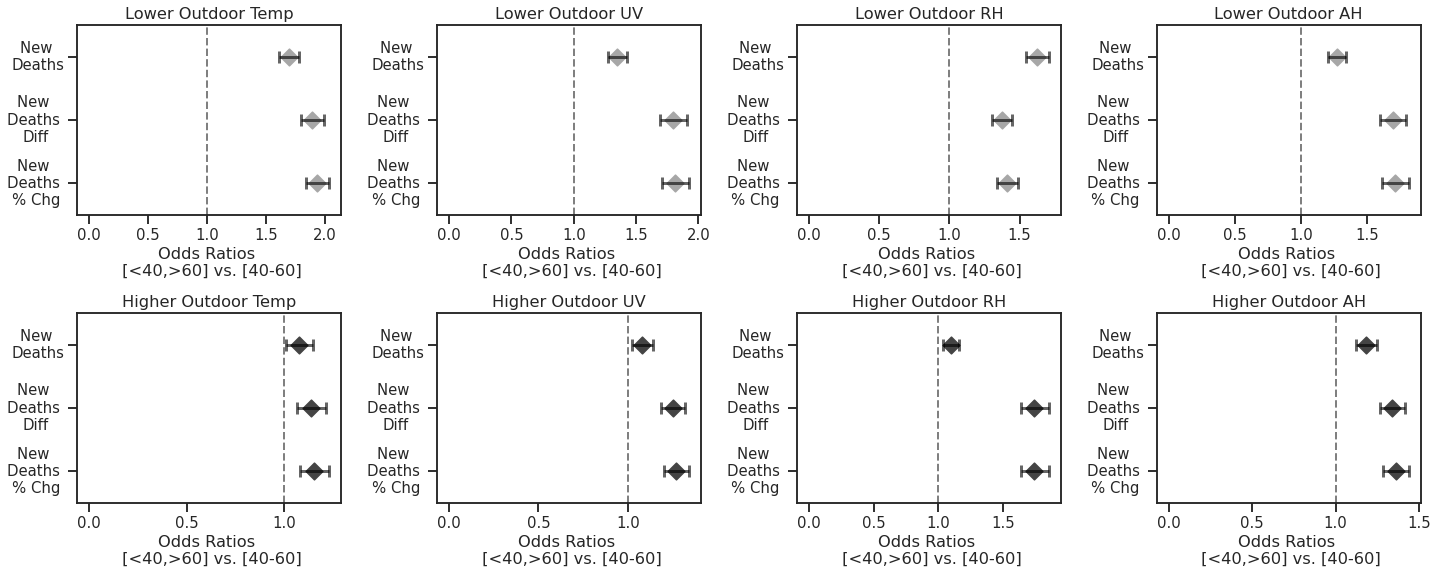

In [ ]:
# Set up the plotting 
quantized_outcomes = ['new_deaths_Qlevels','new_deaths_diff_Qlevels','new_deaths_pctchange_Qlevels']
keys = dict_stratify_by_weather.keys()

rows = control_qlevels; cols = len(keys); fig,ax=plt.subplots(rows,cols,figsize=(20,8))

points = []; lines=[]

col=0
for key in keys: # Each key will get a new column (so you have 4 columns, Temp, UV, RH, AH)

  for row in range(0,rows): # Each row corresponds to the stratum (top row = 0, bottom row = 1)

    for outcome in range(len(quantized_outcomes)):
      
      data_for_plotting = df_pooled_ORs_byweather.loc[(key,quantized_outcomes[outcome],row)]

      ax[row,col].errorbar(x=data_for_plotting['pooled_OR'],y=outcome,xerr=np.array([data_for_plotting['pooled_OR']-data_for_plotting['pooled_OR_lowerCI'],data_for_plotting['pooled_OR_upperCI']-data_for_plotting['pooled_OR']]).reshape(-1,1),capsize=6,capthick=3,elinewidth=3,ecolor='k',alpha=0.6,dash_capstyle='butt')
      points.append(ax[row,col].scatter(data_for_plotting['pooled_OR'],outcome,marker='D',color='k',alpha=1,s=140))
      ax[row,col].set_yticks(range(0,len(quantized_outcomes)))
      ax[row,col].set_yticklabels(['New \nDeaths','New \nDeaths \nDiff','New \nDeaths \n% Chg'],ha='right', va='center',multialignment='center')

  col+=1

ax[0,0].set_title('Lower Outdoor Temp')
ax[1,0].set_title('Higher Outdoor Temp')
ax[0,1].set_title('Lower Outdoor UV')
ax[1,1].set_title('Higher Outdoor UV')
ax[0,2].set_title('Lower Outdoor RH')
ax[1,2].set_title('Higher Outdoor RH')
ax[0,3].set_title('Lower Outdoor AH')
ax[1,3].set_title('Higher Outdoor AH')

[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[4]) for i in range(0,3)]
[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[4]) for i in range(6,9)]
[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[4]) for i in range(12,15)]
[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[4]) for i in range(18,21)]

[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[0]) for i in range(3,6)]
[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[0]) for i in range(9,12)]
[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[0]) for i in range(15,18)]
[points[i].set_color(sns.color_palette(palette='Greys_d',n_colors=5)[0]) for i in range(21,24)]

[ax.set_xlabel('Odds Ratios \n [<40,>60] vs. [40-60]') for ax in plt.gcf().axes]
[ax.set_ylim(-.5,2.5) for ax in plt.gcf().axes]
[ax.axvline(x=0,color='grey',alpha=0.0,linewidth=0) for ax in plt.gcf().axes]
[ax.axvline(x=1,linestyle='--',color='grey',alpha=1,linewidth=2) for ax in plt.gcf().axes]
[ax.invert_yaxis() for ax in plt.gcf().axes]
fig.tight_layout(pad=0.5,h_pad=1,w_pad=1)